In [119]:
import os
import sys
import math
import argparse
import numpy as np
from collections import Counter
import xml.etree.ElementTree as et 

# Keras imports
from keras.models import Model
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras.layers import Input, Dense, Dropout, AlphaDropout, BatchNormalization, Activation

# ML4CVD Imports
sys.path.append("../ml4cvd")
from plots import plot_ecg
from arguments import parse_args
from recipes import train_multimodal_multitask

%matplotlib inline
import matplotlib.pyplot as plt


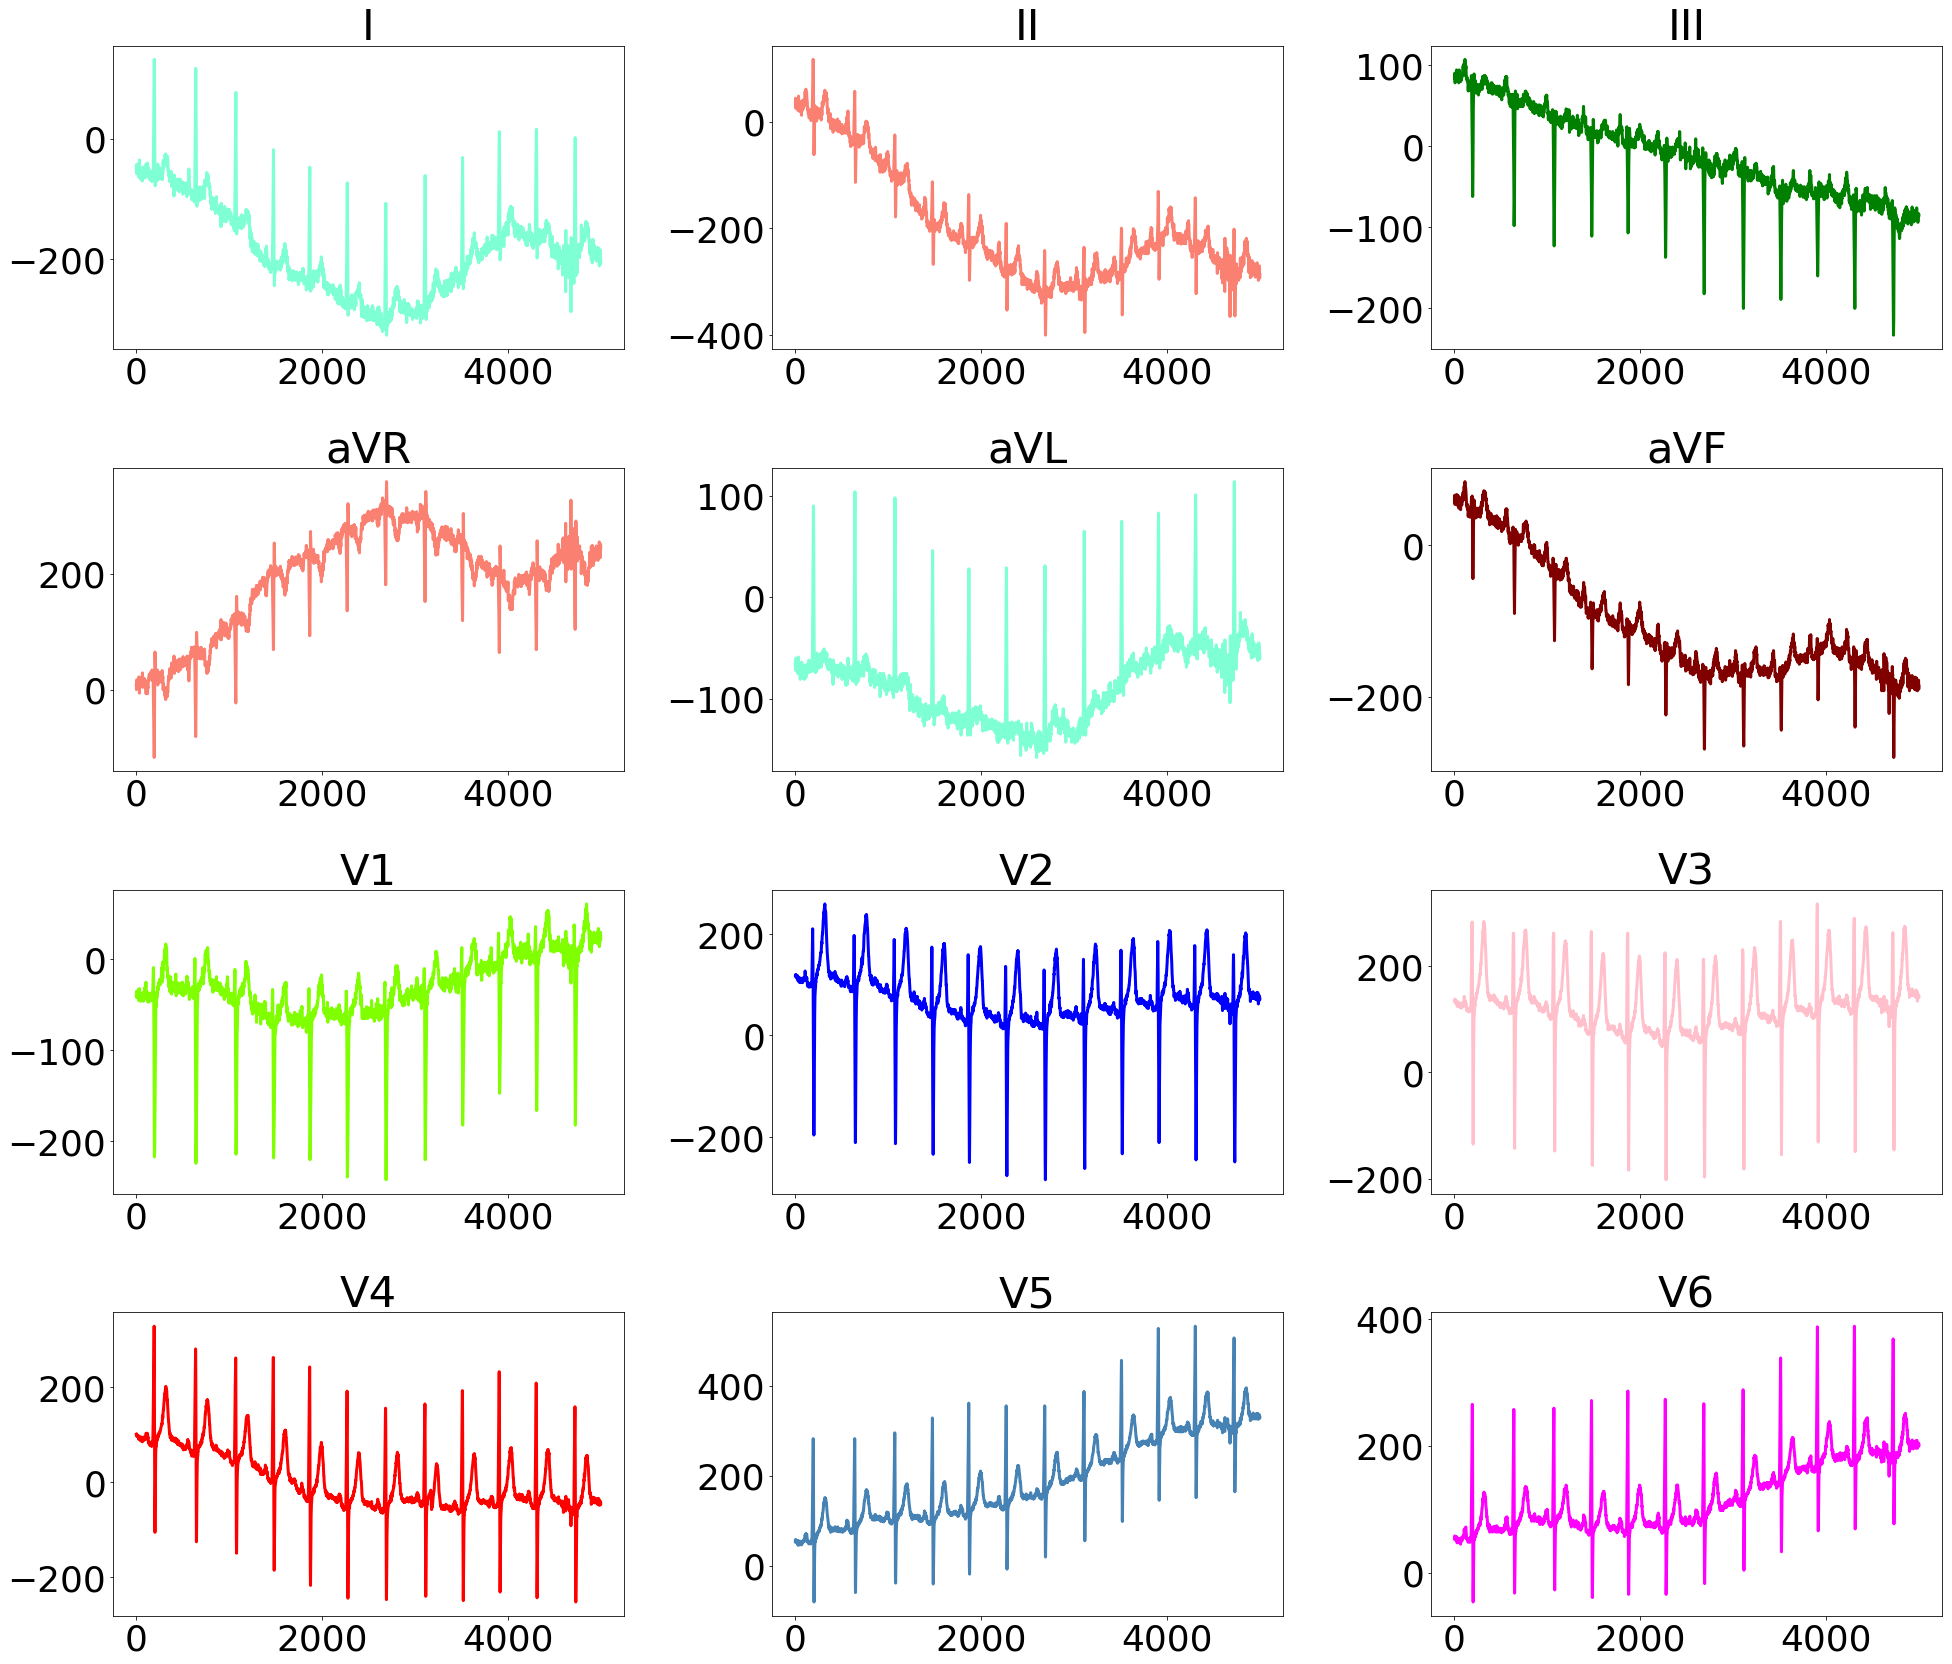

In [125]:
strip_ekgs = {}
ffts = {}
xml_file = '/mnt/disks/data/raw/ecgs/5223300_20205_2_0.xml'

root = et.parse(xml_file).getroot()
for c in root.findall("./StripData/WaveformData"):
    strip_ekgs[c.attrib['lead']] = np.array(list(map(float, c.text.strip().split(','))))

plot_ecg(strip_ekgs, 'strip')

DiagnosisVersion 12SL V21
VentricularRate 73
PQInterval 176
PDuration 90
QRSDuration 86
QTInterval 390
QTCInterval 429
RRInterval 822
PPInterval 820
SokolovLVHIndex None
PAxis 68
RAxis -20
TAxis 40
QTDispersion None
QTDispersionBazett None
QRSNum 12
MeasurementTable 
			
POnset 252
POffset 342
QOnset 428
QOffset 514
TOffset 818
MedianSamples 
			
Normal sinus rhythm
Normal ECG

Arrhythmia results of the fulldisclosure ECG
   QRS Complexes 22


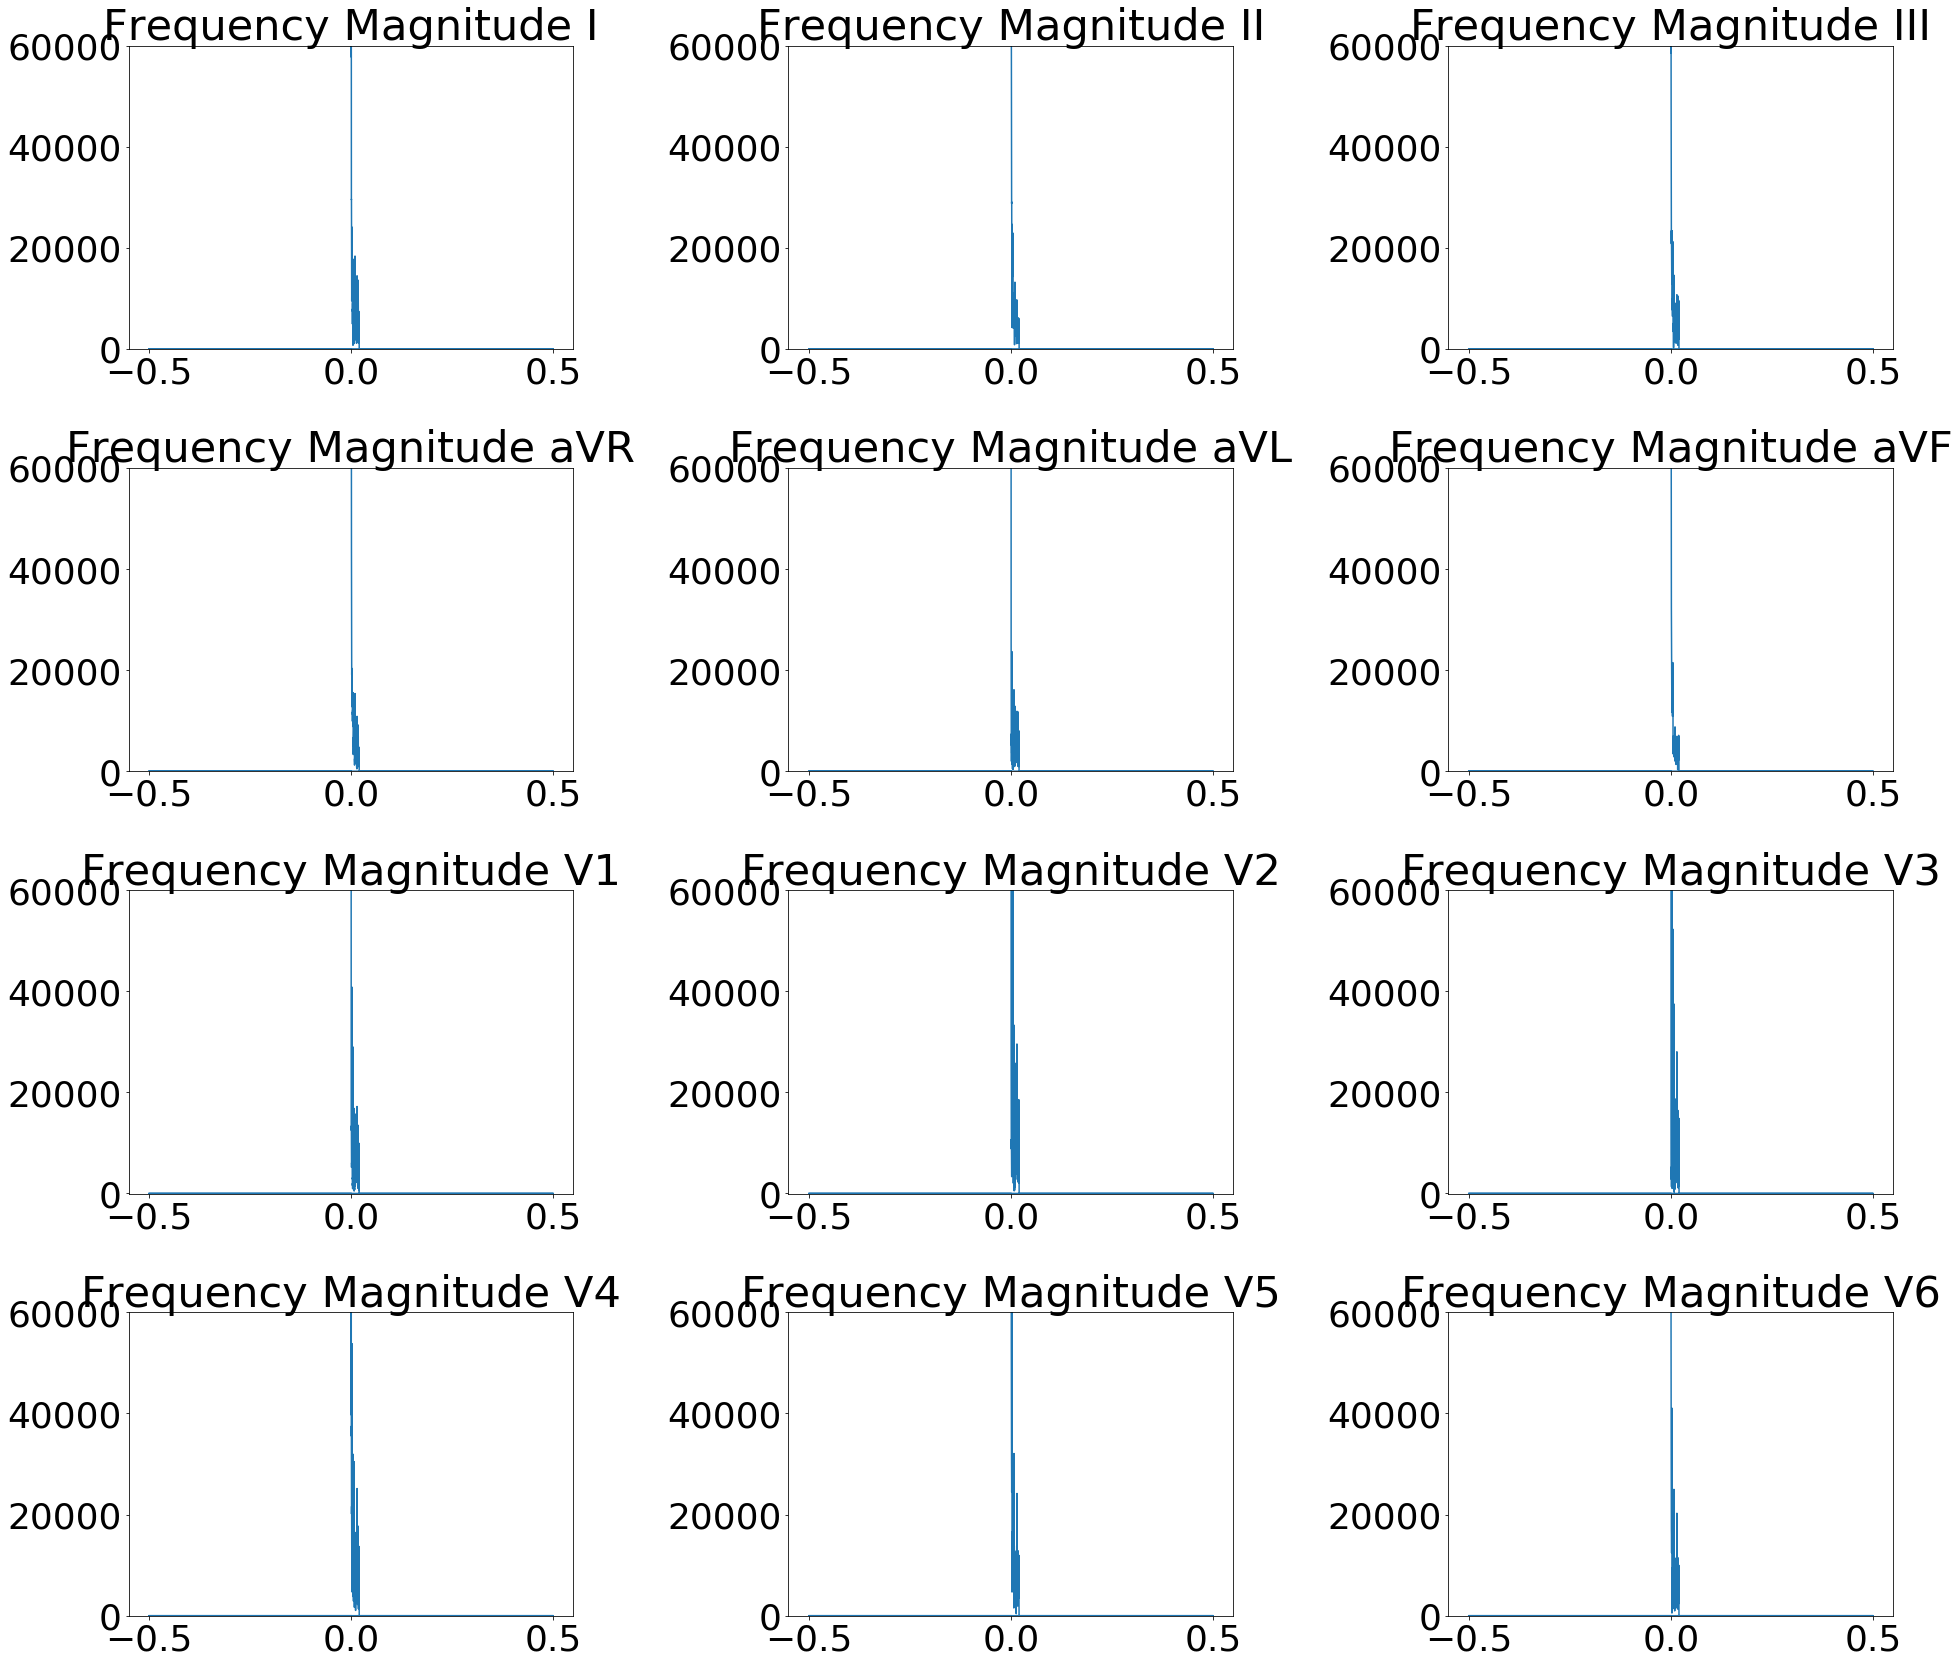

In [126]:
for c in root.findall("./RestingECGMeasurements"):
    for child in c:
        print(child.tag, child.text)
        
for d in root.findall("./Interpretation/Diagnosis/DiagnosisText"):
	diagnosis = ''.join(e for e in d.text if e.isalnum() or e == ' ')
	print(diagnosis)

rows = int(math.ceil(math.sqrt(len(strip_ekgs))))
cols = math.ceil(len(strip_ekgs)/rows)
fig, axes = plt.subplots(rows, cols, figsize=(28,24))
ffts = {}
filtered = {}
start_filter = 0
end_filter = 100
band_pass = True  # otherwise band block
for i,k in enumerate(strip_ekgs):
    ax = plt.subplot(rows, cols, i+1)
    ax.set_title('Frequency Magnitude '+k)
    ffts[k] = np.fft.fft(strip_ekgs[k])
    freq = np.fft.fftfreq(ffts[k].shape[-1])
    if band_pass:
        ffts[k][:start_filter] = np.zeros((start_filter,))
        ffts[k][end_filter:] = np.zeros((len(ffts[k])-end_filter,))
    else:
        ffts[k][start_filter:end_filter] = np.zeros(np.abs(end_filter-start_filter,))  
    filtered[k] = np.fft.ifft(ffts[k])
    ax.plot(freq, np.abs(ffts[k]))
    ax.set_ylim([-20, 60000])
plt.tight_layout()
plt.show()

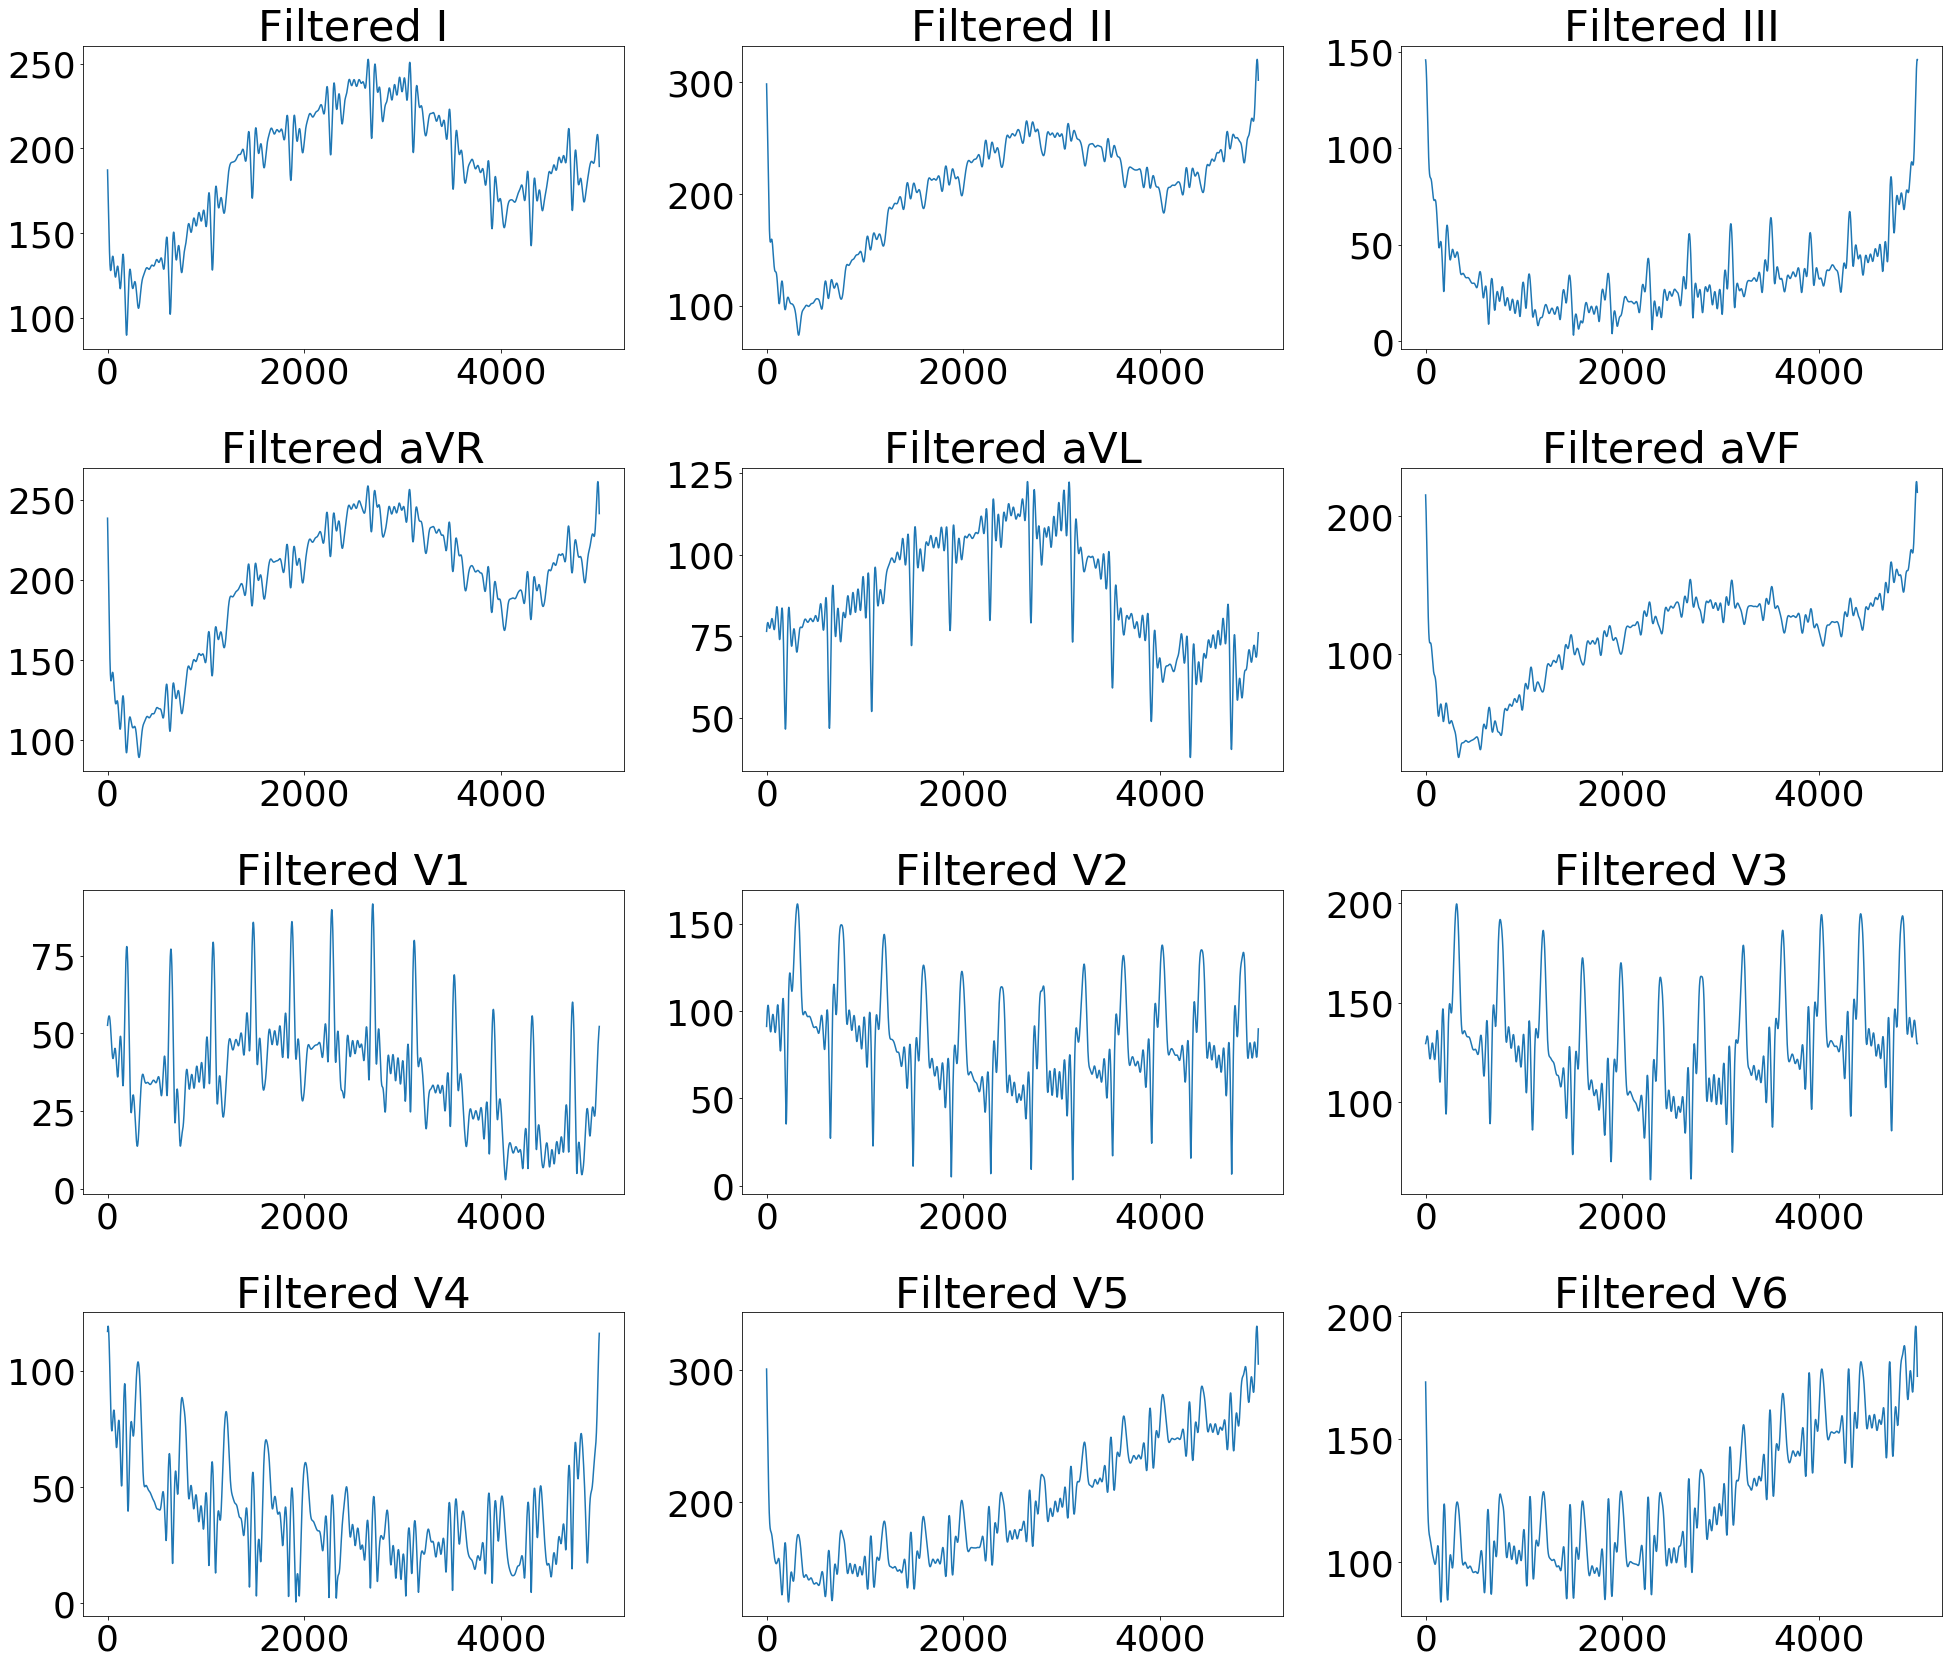

In [127]:

rows = int(math.ceil(math.sqrt(len(ffts))))
cols = math.ceil(len(ffts)/rows)
fig, axes = plt.subplots(rows, cols, figsize=(28,24))
for i,k in enumerate(filtered):
    ax = plt.subplot(rows, cols, i+1)
    ax.set_title('Filtered '+k)
    ax.plot(np.abs(filtered[k]))
    #ax.set_ylim([-20, 60000])
    #ax.set_xlim([-0.06, 0.06])
plt.tight_layout()
plt.show()    

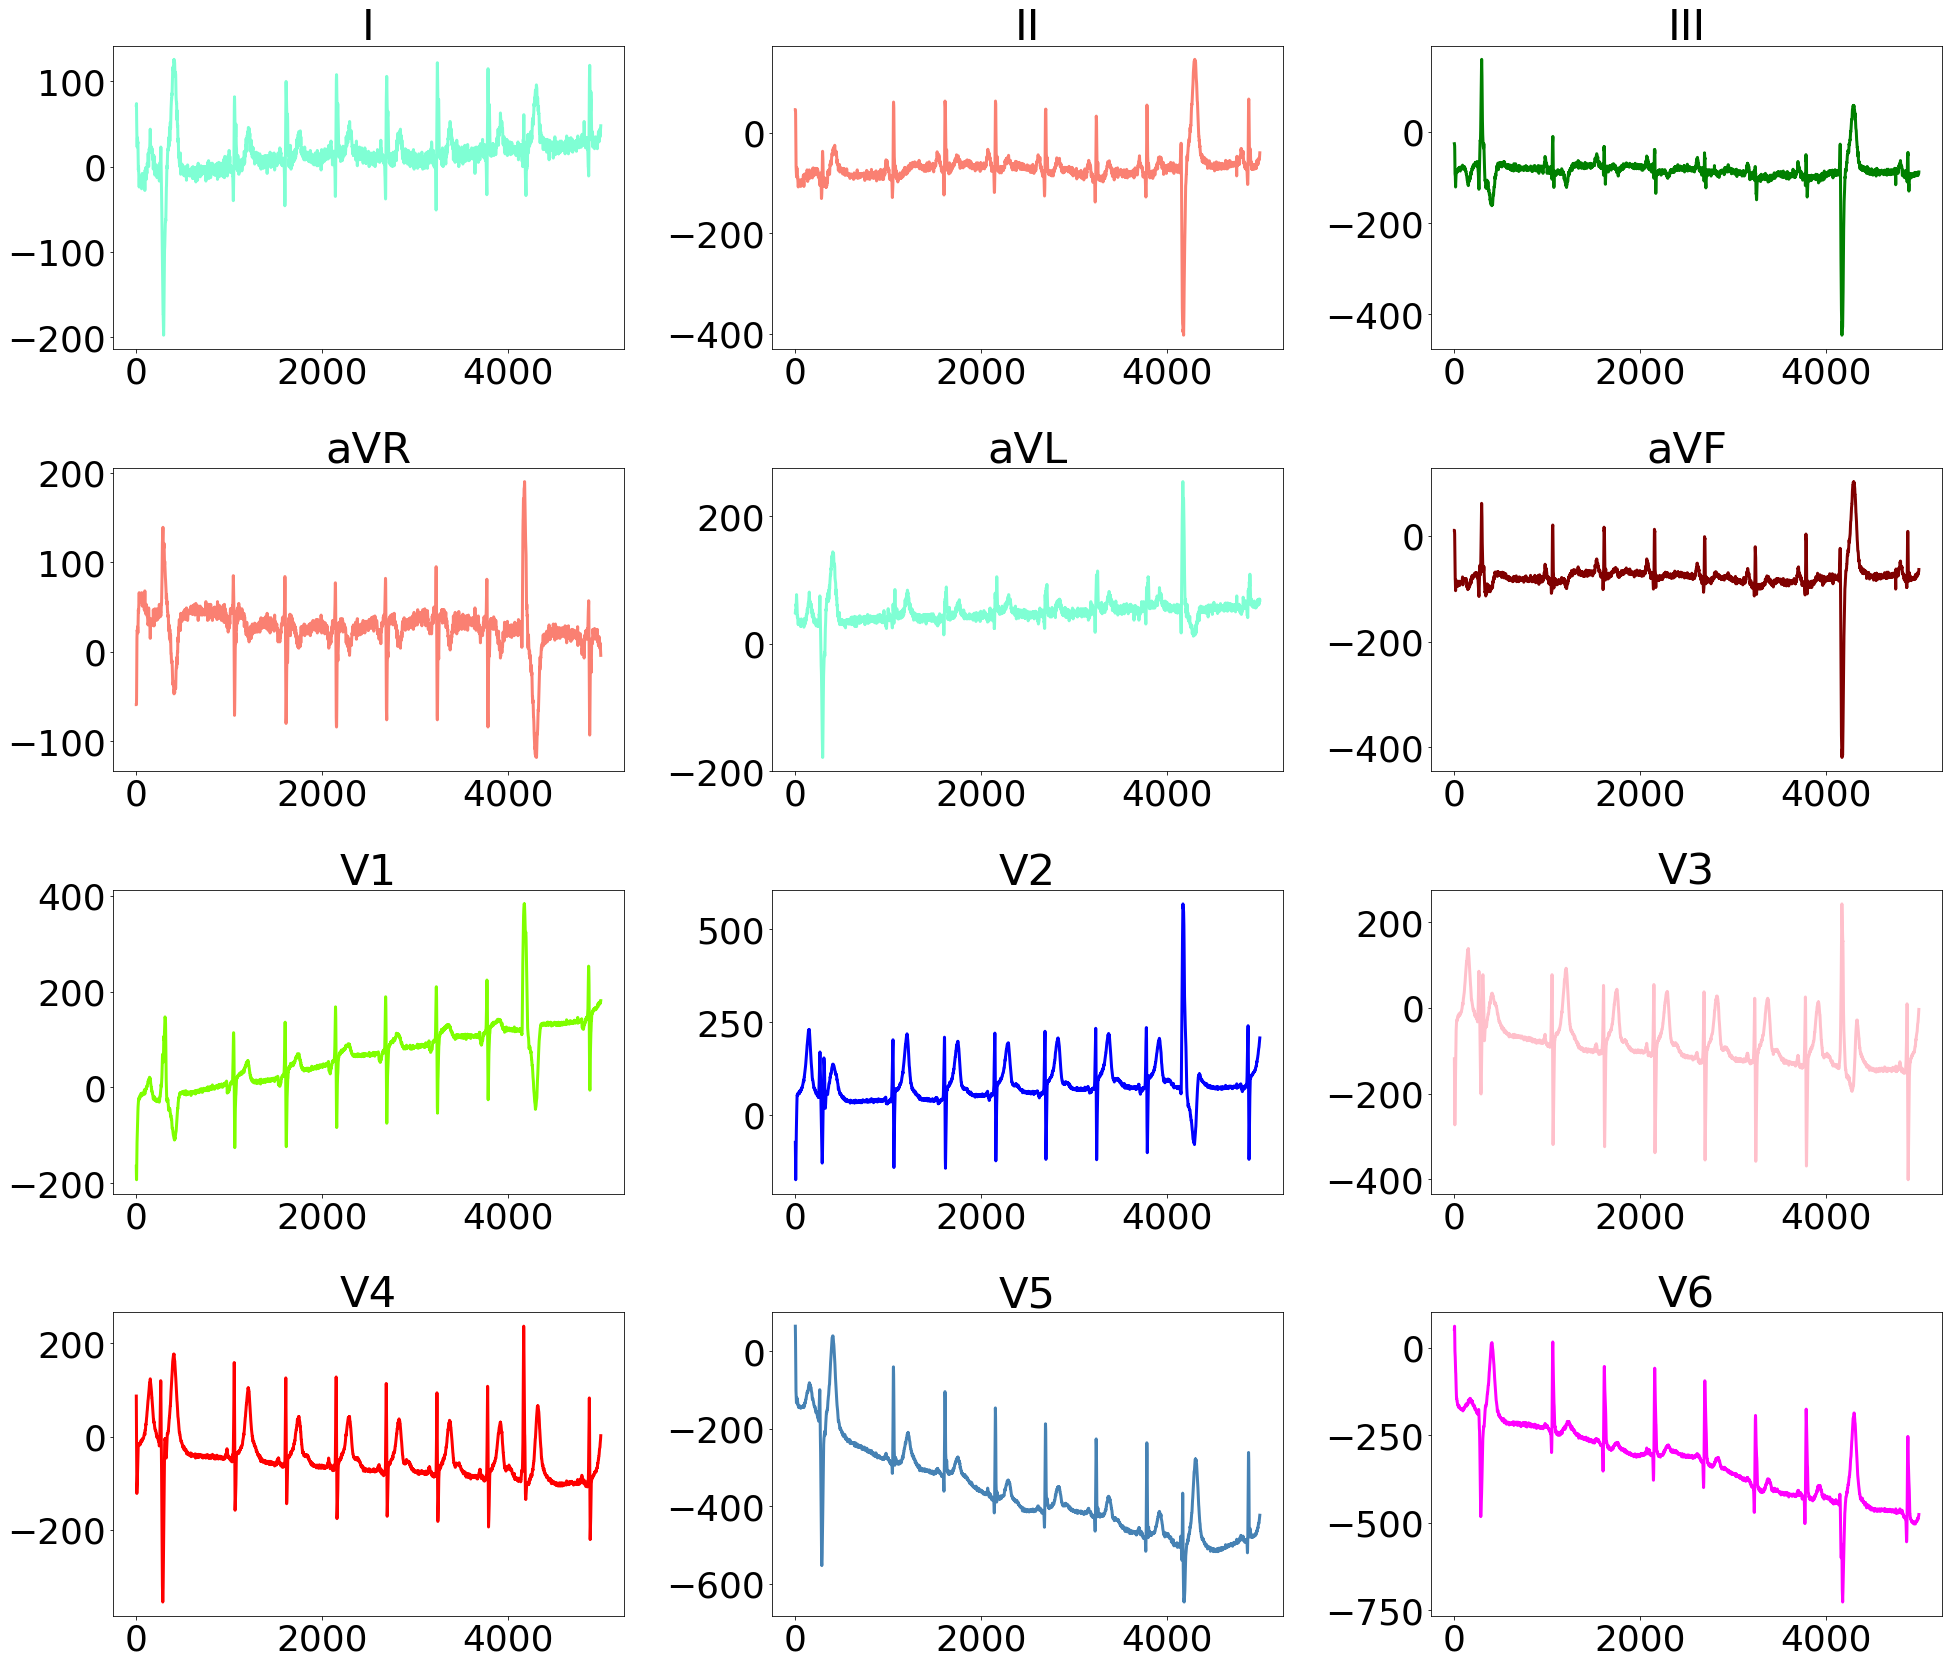

In [101]:
xml_file = '/mnt/disks/data/raw/ecgs/4856206_20205_2_0.xml'

root = et.parse(xml_file).getroot()
for c in root.findall("./StripData/WaveformData"):
    strip_ekgs[c.attrib['lead']] = np.array(list(map(float, c.text.strip().split(','))))
    ffts[c.attrib['lead']] = np.fft.fft(strip_ekgs[c.attrib['lead']])

plot_ecg(strip_ekgs, 'strip_bradycardia')

Sinus bradycardia with occasional premature ventricular complexes
Lateral infarct  age undetermined
Possible Inferior infarct  age undetermined
Abnormal ECG

Arrhythmia results of the fulldisclosure ECG
   QRS Complexes 2


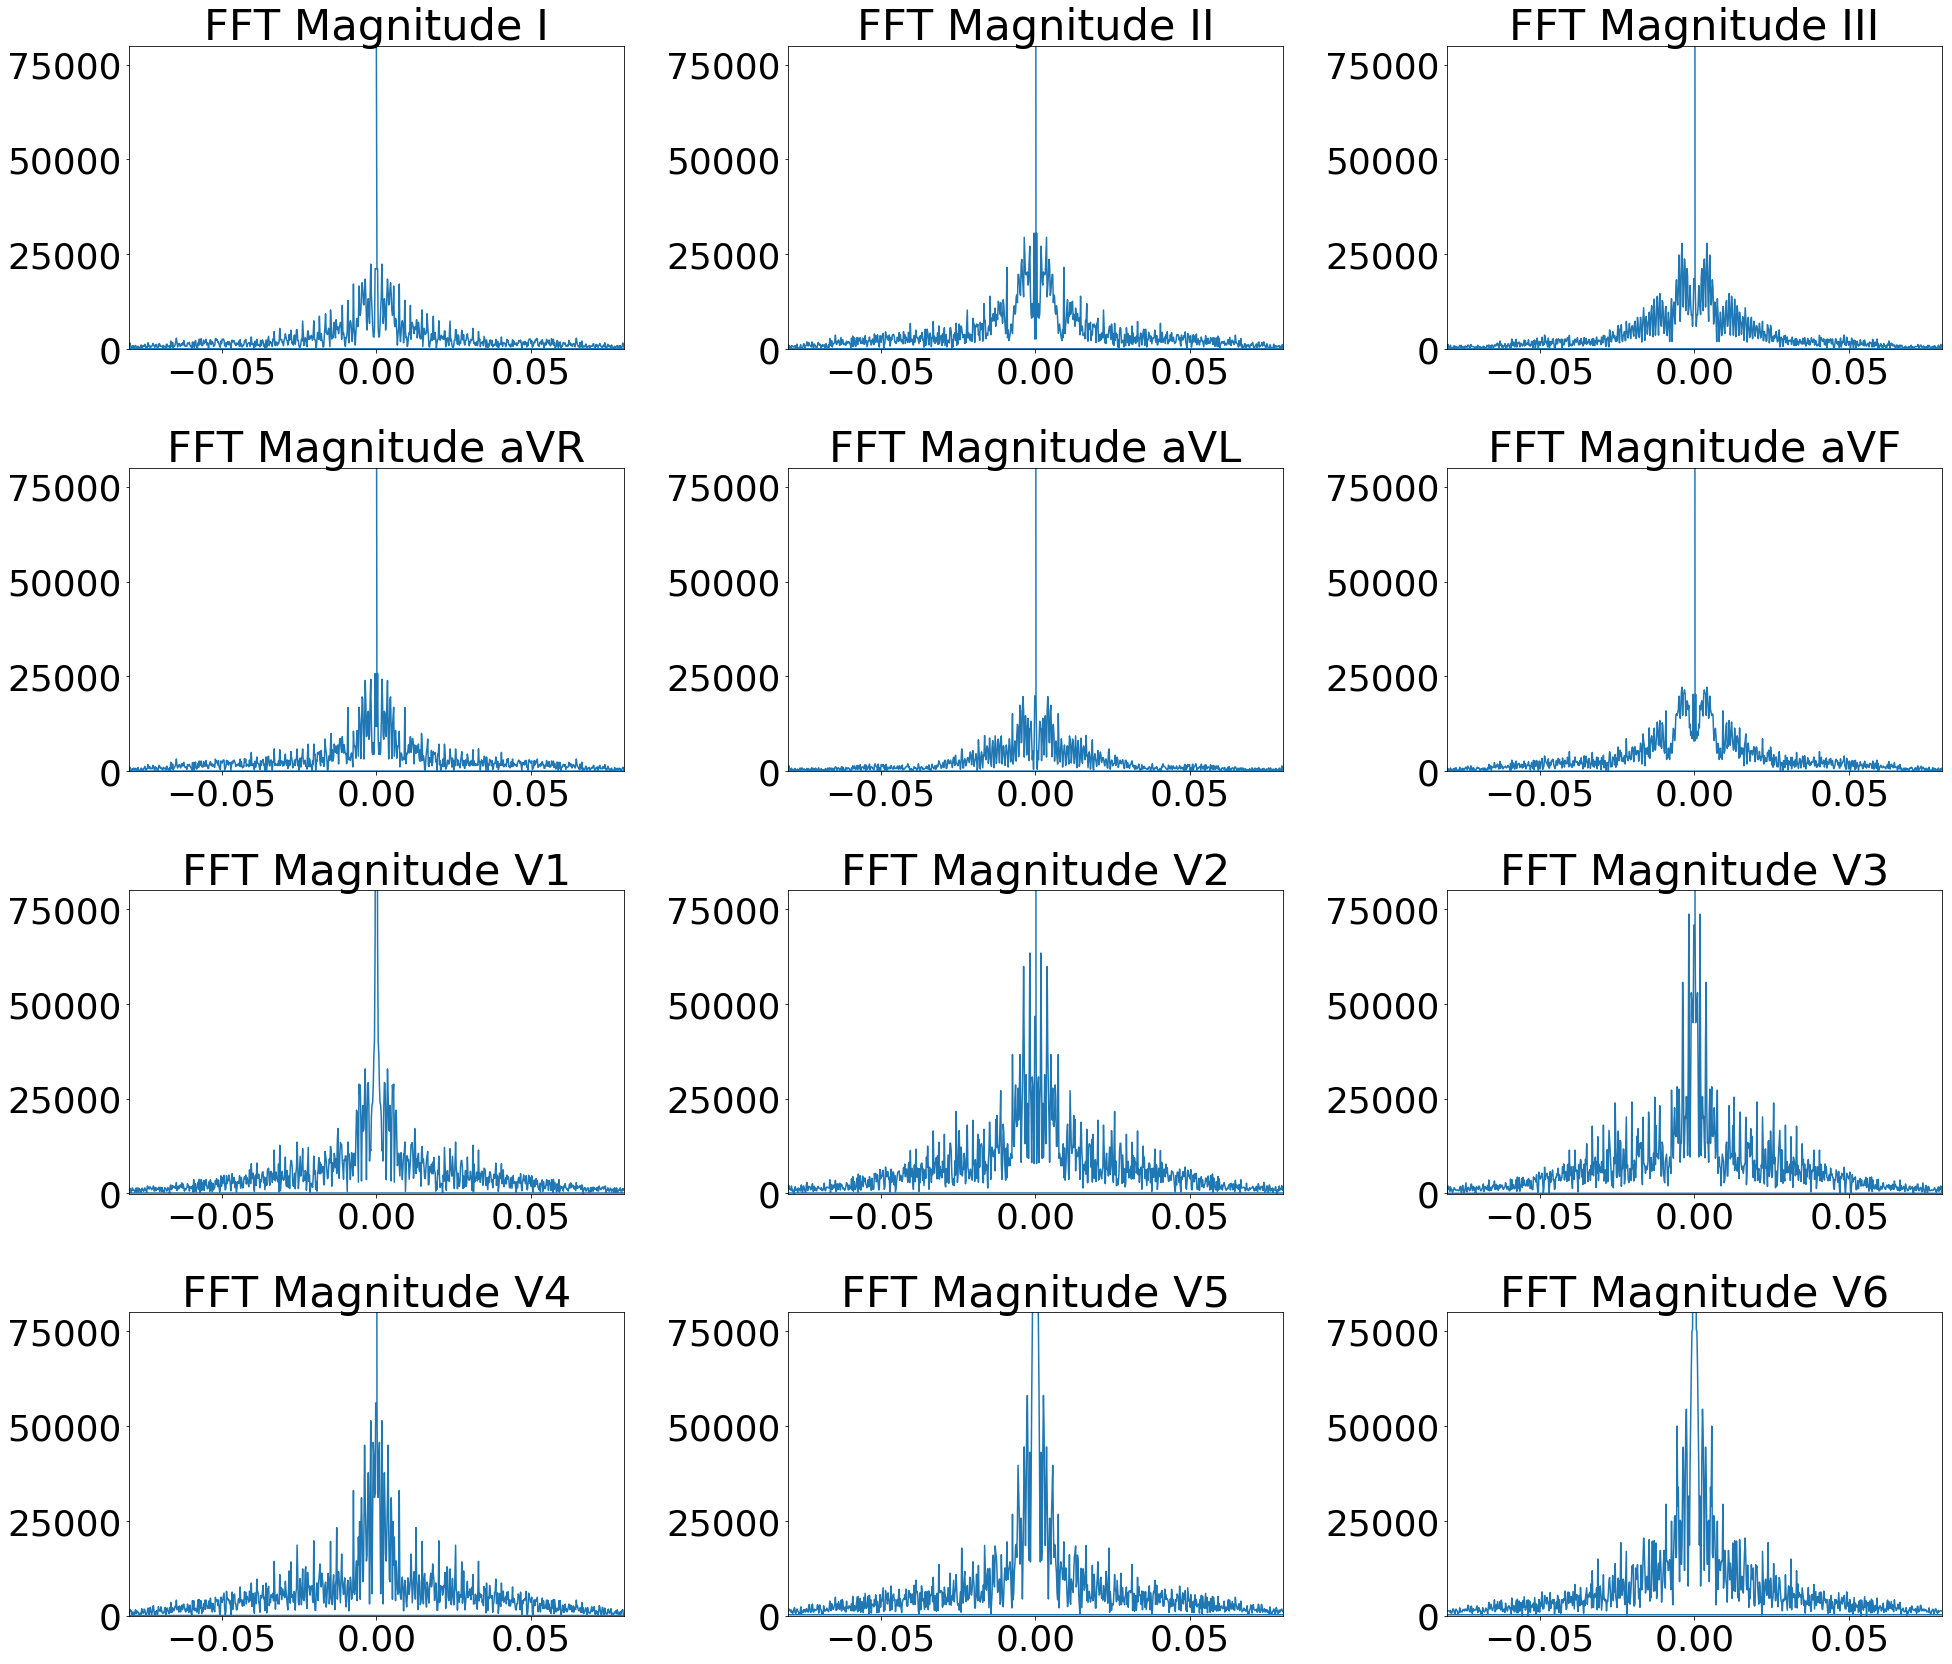

In [5]:
root = et.parse(xml_file).getroot()
for d in root.findall("./Interpretation/Diagnosis/DiagnosisText"):
    diagnosis = ''.join(e for e in d.text if e.isalnum() or e == ' ')
    print(diagnosis)

rows = int(math.ceil(math.sqrt(len(ffts))))
cols = math.ceil(len(ffts)/rows)
fig, axes = plt.subplots(rows, cols, figsize=(28,24))

for i,k in enumerate(ffts):
    ax = plt.subplot(rows, cols, i+1)
    ax.set_title('FFT Magnitude '+k)
    freq = np.fft.fftfreq(ffts[k].shape[-1])
    ax.plot(freq, np.abs(ffts[k]))
    ax.set_ylim([-20, 80000])
    ax.set_xlim([-0.08, 0.08])
plt.tight_layout()
plt.show()

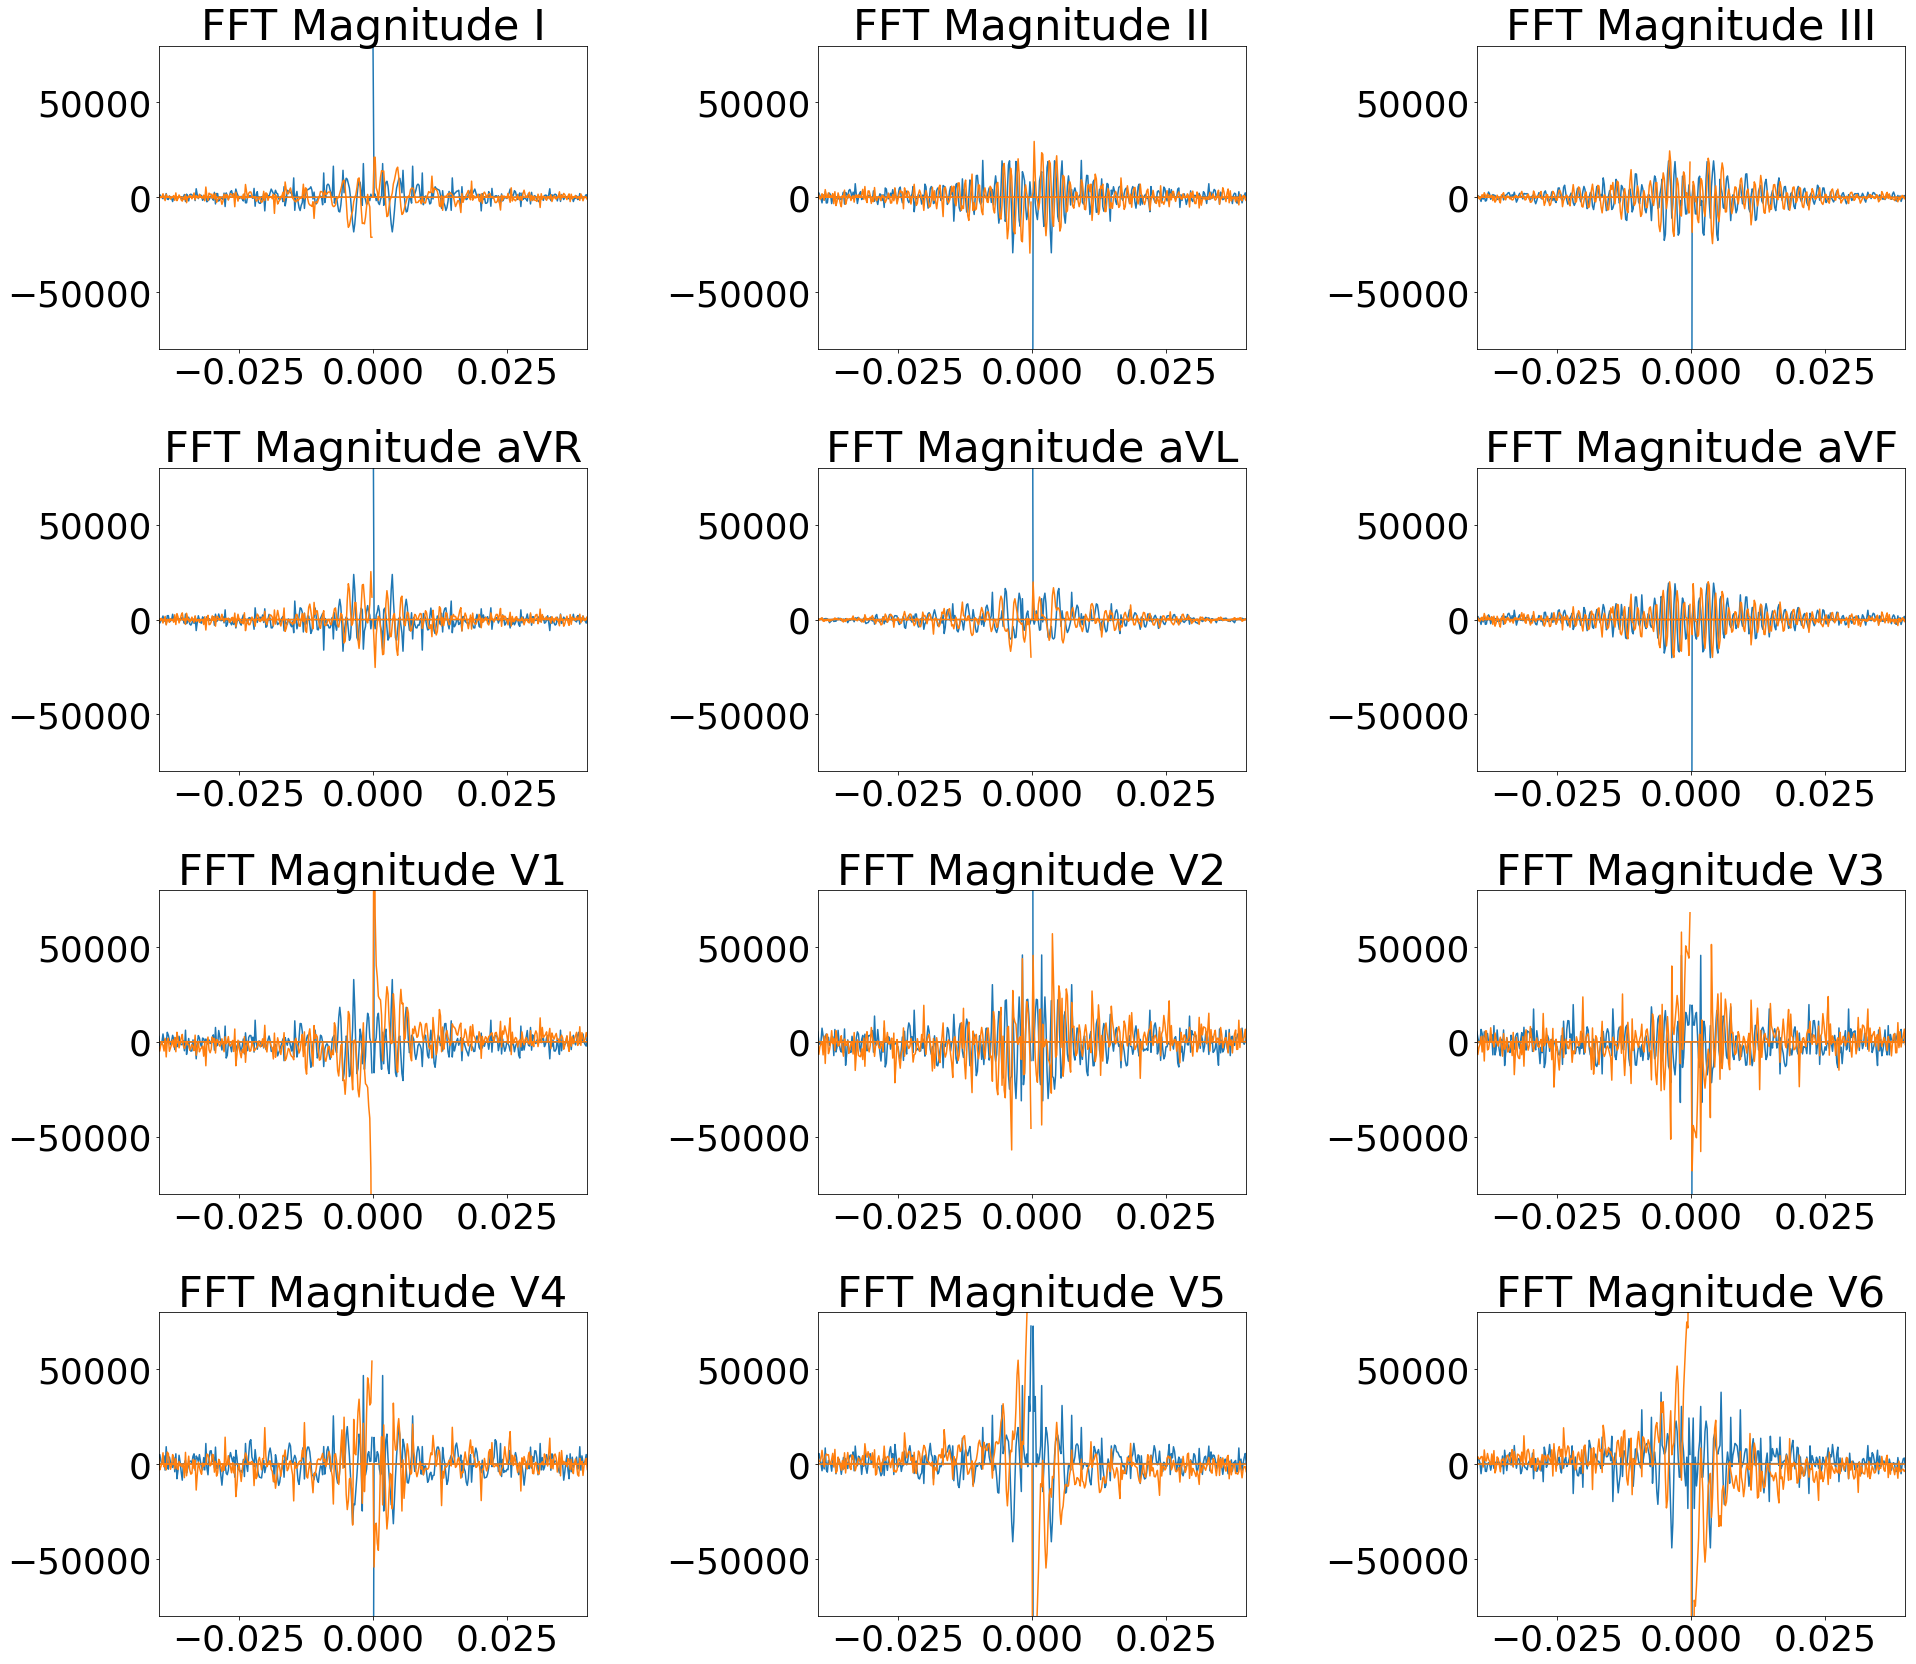

In [6]:
fig, axes = plt.subplots(rows, cols, figsize=(28,24))
for i,k in enumerate(ffts):
    ax = plt.subplot(rows, cols, i+1)
    ax.set_title('FFT Magnitude '+k)
    freq = np.fft.fftfreq(ffts[k].shape[-1])
    ax.plot(freq, ffts[k].real, freq, ffts[k].imag)
    ax.set_ylim([-80000, 80000])
    ax.set_xlim([-0.04, 0.04])
plt.tight_layout()
plt.show()